#Introduction

.....


Check to see if jupyter lab uses the correct python interpreter with '!which python'.
It should be something like '/opt/anaconda3/envs/[environment name]/bin/python' (on Mac).
If not, try this: https://github.com/jupyter/notebook/issues/3146#issuecomment-352718675

In [1]:
!which python

Der Befehl "which" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


# Install dependencies:

In [2]:
install_packages = False
if install_packages:
    !conda install tensorflow=2 -y
    !conda install -c anaconda pandas -y
    !conda install -c conda-forge tensorflow-hub -y
    !conda install -c akode html2text -y
    !conda install -c conda-forge tqdm -y
    !conda install -c anaconda scikit-learn -y
    !conda install -c conda-forge matplotlib -y
    !conda install -c anaconda seaborn -y

# Imports

In [3]:
#imports
import pandas as pd
import numpy as np
import os
import time
import tensorflow as tf
import tensorflow_hub as hub
import zipfile
from html2text import HTML2Text
from tqdm import tqdm
import re
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns

# Set pandas print options
This will improve readability of printed pandas dataframe.


In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Set global Parameters
Set your parameters here:

data_path: In this path put the data you have downloaded with YouTube Data Tools. 
output_path: Tghe files generated in this notebook will be saved here.

url_dict: URLs to models on Tensorflow hub are saved here. Other models are available there.
model_type: Define which model you would like to use. Choose one from url_dict

new_embeddings: If this is true, new embeddings will be generated and saved at output_path. Otherwise, embeddings are loaded from Disc.




In [5]:
data_path = './data/videoinfo_XGVUV2tpR5g_2020_11_22-16_27_17_comments.csv'
output_path = "./output/"

new_embeddings = True

url_dict = {
            'Transformer' : "https://tfhub.dev/google/universal-sentence-encoder-large/5",
            'DAN' : "https://tfhub.dev/google/universal-sentence-encoder/4",
            'Transformer_Multilingual': "https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3"
}

model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

## Create output directory
Try to create the directory defined by output_path

In [6]:
try:
    os.mkdir(output_path)
except OSError:
    print ("Creation of the directory %s failed" % output_path)
else:
    print ("Successfully created the directory %s " % output_path)


Creation of the directory ./output/ failed


# Load Data
Load you data as a pandas dataframe

In [7]:
if new_embeddings:
    data = pd.read_csv(data_path,sep='\t',header=(0))
    data.head()

# Preprocessing
Preprocess your data:
- Drop empty rows
- Drop unused columns

In [8]:
if new_embeddings:
    data = data.dropna(subset=['text', 'authorName']) # drop rows with no content
    data=data.drop(['id', 'replyCount','likeCount','authorChannelUrl','authorChannelId','isReplyTo','isReplyToName'],axis=1) # drop unused columns
    data.head()

- remove HTML-tags, links and usernames

In [9]:
if new_embeddings:
    # Remove HTML tags
    tqdm.pandas()
    h = HTML2Text()
    h.ignore_links = True
    data['cleaned'] = data['text'].progress_apply(lambda x: h.handle(x))
    print( "Removed HTML Tags.")

    # Remove links
    http_link_pattern = r'http\S+'
    bitly_link_pattern = r'bit.ly/\S+'
    data['cleaned'] = data['cleaned'].str.replace(http_link_pattern, '')
    data['cleaned'] = data['cleaned'].str.replace(bitly_link_pattern, '')
    print( "Removed Links.")

    # Remove user names
    keep_names = ["earth", "Tide", "Geologist", "A Person", "Titanic", "adventure", "Sun", "The United States Of America"] # user names we want to keep
    user_names = [name for name in data['authorName'].unique() if (len(name)> 3 and name not in keep_names)]
    data['cleaned'] = data['cleaned'].str.replace('|'.join(map(re.escape, user_names)), '')
    print( "Removed user names.")

C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████████████████████████████████████████████████████████████████████████| 769/769 [00:00<00:00, 7949.69it/s]


Removed HTML Tags.
Removed Links.
Removed user names.


# Save or Load preprocessed data

Save your data afte preprocessing, or load preprocessed data from disc.

In [10]:
if new_embeddings:
    data.to_pickle(output_path+'data_preprocessed'+'.pkl')
else:
    data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
data.head()

,publishedAt,authorName,text,isReply,cleaned
0,2020-11-22 10:41:22,Pfötchen,❤,0,❤\n\n
1,2020-11-21 10:28:58,Der Rezensent,Habt ihr von der AfD wirklich keine Agenden mehr mit politischen Inhalten und müsst nun stattdessen eure freilaufenden Mitläufer in den Bundestag schicken um eure Kontrahenten mittels persönlichem Angehen zu verschrecken? War das so gemeint mit: &quot;Wir werden sie jagen!&quot;? Was kommt als Nächstes? Lasst ihr nun &quot;auf Kinder schießen&quot;? ako Frau von Storch! Ist damit gemeint: &quot;Wir holen uns unser Land zurück!&quot;? Oder war das Ganze nur ein &quot;Vogelschiss&quot;?,0,"Habt ihr von der AfD wirklich keine Agenden mehr mit politischen Inhalten und\nmüsst nun stattdessen eure freilaufenden Mitläufer in den Bundestag schicken\num eure Kontrahenten mittels persönlichem Angehen zu verschrecken? War das so\ngemeint mit: ""Wir werden sie jagen!""? Was kommt als Nächstes? Lasst ihr nun\n""auf Kinder schießen""? ako Frau von Storch! Ist damit gemeint: ""Wir holen uns\nunser Land zurück!""? Oder war das Ganze nur ein ""Vogelschiss""?\n\n"
2,2020-11-19 20:33:44,Baggi Djunglebook,Glaube nur der Statistik dir Du selber gefälscht hast. <br /><br />Passt.,0,Glaube nur der Statistik dir Du selber gefälscht hast. \n \nPasst.\n\n
3,2020-11-19 09:59:11,Peter Penner,"...die Bildung in Deutschland wurde in der letzten 30 Jahre sehr vernachlässigt - das habe ich gemärkt als ich 1989 nach Deutschland kam und meine Kinder, eines nach dem anderen zur Schule gingen. Weswegen müssen wir uns auch nicht wundern, das man ihnen alles vorgaukeln kann.",0,"...die Bildung in Deutschland wurde in der letzten 30 Jahre sehr\nvernachlässigt - das habe ich gemärkt als ich 1989 nach Deutschland kam und\nmeine Kinder, eines nach dem anderen zur Schule gingen. Weswegen müssen wir\nuns auch nicht wundern, das man ihnen alles vorgaukeln kann.\n\n"
4,2020-11-19 08:39:25,Paul Leitner,Sehr sehr schöne Rede :D,0,Sehr sehr schöne Rede :D\n\n


# Produce Text Embeddings with Universal Sentence Encoder

## Load Model
Load the model from TF-hub

In [11]:
hub_url = url_dict[model_type]
if new_embeddings:
    print("Loading model. This will take some time...")
    embed = hub.load(hub_url)

Loading model. This will take some time...


## Embed Documents
Produce embeddings of your documents.

In [12]:
if new_embeddings:
    for k,g in data.groupby(np.arange(len(data))//200):
        if k == 0:
            embeddings = embed(g['cleaned'])
        else:
            embeddings_new = embed(g['cleaned'])
            embeddings = tf.concat(values=[embeddings,embeddings_new],axis = 0)
            print(k , end =" ")
    print("The embeddings vector is of fixed length {}".format(embeddings.shape[1]))

    np.save(output_path+'/embeddings'+model_type+'.npy', embeddings, allow_pickle=True, fix_imports=True)
else:
    embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

embeddings.shape

1 2 3 The embeddings vector is of fixed length 512


TensorShape([769, 512])

## Calculate Similarity Matrix with angular distance

'Following Cer et al. (2018), we first compute
the sentence embeddings u, v for an STS sentence
pair, and then score the sentence pair similarity
based on the angular distance between the two
embedding vectors  d = − arccos (uv/||u|| ||v||).'

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
def cos_sim(input_vectors):
    similarity = cosine_similarity(input_vectors)
    return similarity
cosine_similarity_matrix = cos_sim(np.array(embeddings))
print(cosine_similarity_matrix)

[[1.         0.01727337 0.04225923 ... 0.0067451  0.07492081 0.06325494]
 [0.01727337 1.0000002  0.6422694  ... 0.5387074  0.3547926  0.44816566]
 [0.04225923 0.6422694  1.         ... 0.5989609  0.5368384  0.6492388 ]
 ...
 [0.0067451  0.5387074  0.5989609  ... 0.99999976 0.5447934  0.5652996 ]
 [0.07492081 0.3547926  0.5368384  ... 0.5447934  1.0000001  0.5847877 ]
 [0.06325494 0.44816566 0.6492388  ... 0.5652996  0.5847877  1.        ]]


# Plots Similarity 
Plot and print a heat map showing the semantic contextual similarity between comments.

769


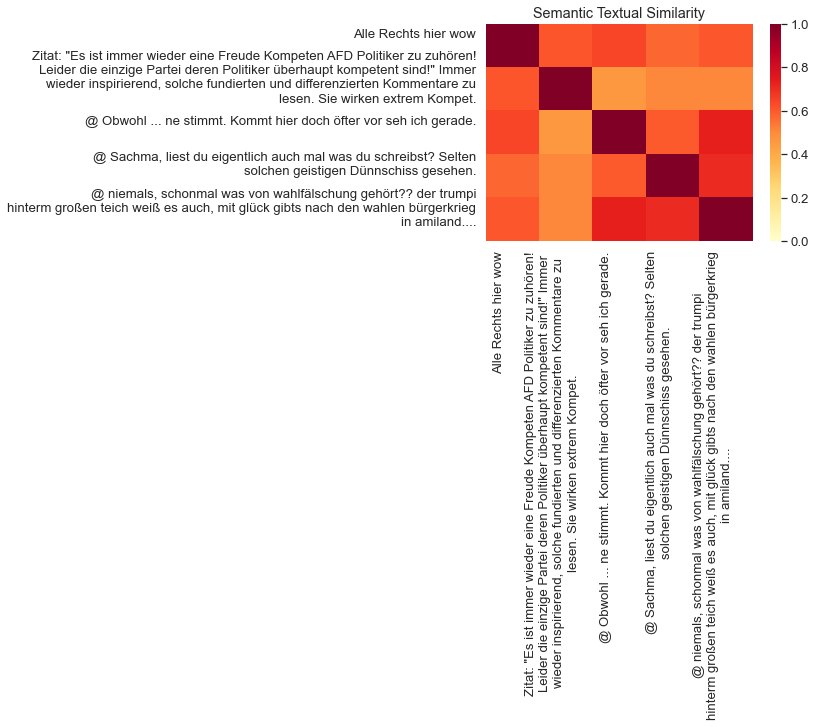

In [14]:
import seaborn as sns
def plot_similarity(labels, features, rotation):
    #print('label: ',labels)
    #print('feature: ',features)
    #print('rotation: ',rotatation)
    corr = np.inner(features, features)
    sns.set(font_scale=1.2)
    g = sns.heatmap(
    corr,
    xticklabels=labels,
    yticklabels=labels,
    vmin=0,
    vmax=1,
    cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")

num_samples = 5
off_set = 700

print(len(data['cleaned']))

plot_similarity(data.iloc[off_set:off_set+num_samples]['cleaned'], embeddings[off_set:off_set+num_samples], 90)

# Show neighbours of a comment 
Define which comment to analyze

In [15]:
comment_index = 324
comment = data["cleaned"][comment_index]
comment_list = data["cleaned"].tolist()
print(comment)

@ Um diskutieren zu können, müsstest du dich erst einmal
anderweitig informieren, bis dahin hast du nichts zu diskutieren.




Print similar comments.

In [18]:
def get_top_similar(sentence, sentence_list, similarity_matrix, topN):
    # find the index of sentence in list
    index = sentence_list.index(sentence)
    # get the corresponding row in similarity matrix
    similarity_row = np.array(similarity_matrix[index, :])
    # get the indices of top similar
    indices = similarity_row.argsort()[-topN:][::-1]
    return [sentence_list[i] for i in indices]


for i, value in enumerate(get_top_similar(comment, comment_list, cosine_similarity_matrix, 750)):
    print("Top similar comment {}: {}".format(i+1, value))

Top similar comment 1: @ Um diskutieren zu können, müsstest du dich erst einmal
anderweitig informieren, bis dahin hast du nichts zu diskutieren.


Top similar comment 2: Ich glaube nicht dass die Pfosten da unten dieses Märchen verstehen,
hochgebildet wie die nun mal sind.


Top similar comment 3: wie heißt es doch schön: Sie haben ja Recht, aber ich sehe das anders...


Top similar comment 4: Die Argumente sind ja bekannt. Gegenargument ist dann, dass sich das Klima
noch nie so schnell verändert hat...


Top similar comment 5: Falsch! Es gibt neben den strunzdämlichen Altparteien viele gute Kleinparteien
mit kompetenten Politikern :)


Top similar comment 6: So viel Inkompetenz kann man sich nicht geben!


Top similar comment 7: Endlich sagt es mal einer! Dankeschön 🙏


Top similar comment 8: @ Doch, doch. Die haben sogar Ghirnzellen im Kopf. Zwei Stück. Und
das Jeder. Was meinst Du ist da los, wenn die beiden sich mal über den Weg
laufen?


Top similar comment 9: Die Klimahysteriker